In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline

### EDA

In [2]:
#!pip install ydata-profiling

In [3]:
df = pd.read_csv('loan-train.csv')

In [4]:
ProfileReport(df, explorative = True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df = df.drop(['Loan_ID'], axis = 1)

In [6]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [7]:
#plt.figure(figsize = (10, 6))
#sns.heatmap(train.corr(), annot = True, cmap = 'inferno');

### Handling the missing data

In [8]:
cat_features = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Property_Area']
for feature in cat_features:
    df[feature].fillna(df[feature].mode()[0], inplace = True)

C:\Users\HP\AppData\Local\Temp\ipykernel_12652\4239488187.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(df[feature].mode()[0], inplace = True)


In [9]:
num_features = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']
for feature in num_features:
    df[feature].fillna(df[feature].median(), inplace = True)

C:\Users\HP\AppData\Local\Temp\ipykernel_12652\2457797045.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(df[feature].median(), inplace = True)


In [10]:
df.Dependents.value_counts()

Dependents
0     360
1     102
2     101
3+     51
Name: count, dtype: int64

In [11]:
df = df.replace(to_replace = '3+', value = 4)
df['Dependents'] = df['Dependents'].astype(int)

In [12]:
df.Dependents.value_counts()

Dependents
0    360
1    102
2    101
4     51
Name: count, dtype: int64

### Data Visualization

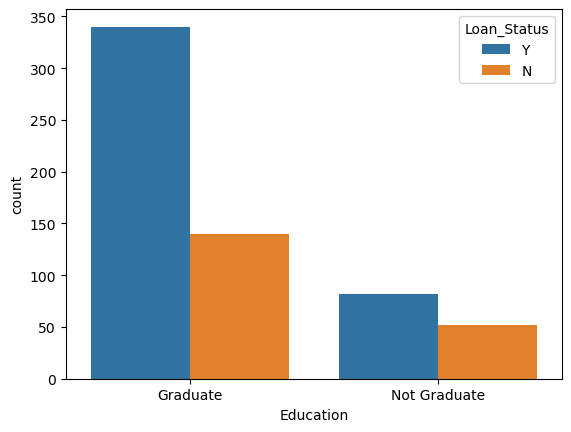

In [13]:
sns.countplot(x = 'Education', hue = 'Loan_Status', data = df)
plt.show()

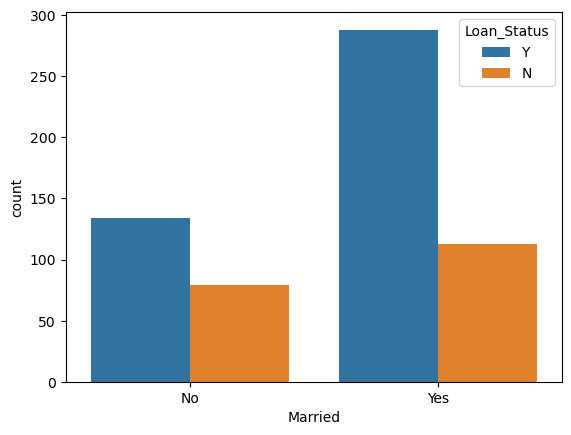

In [14]:
sns.countplot(x = 'Married', hue = 'Loan_Status', data = df)
plt.show()

### Label Encoding

In [15]:
label_encoder = LabelEncoder()
cat_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
for feature in cat_features:
    df[feature] = label_encoder.fit_transform(df[feature])
    
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,128.0,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


### Handling the Outliers

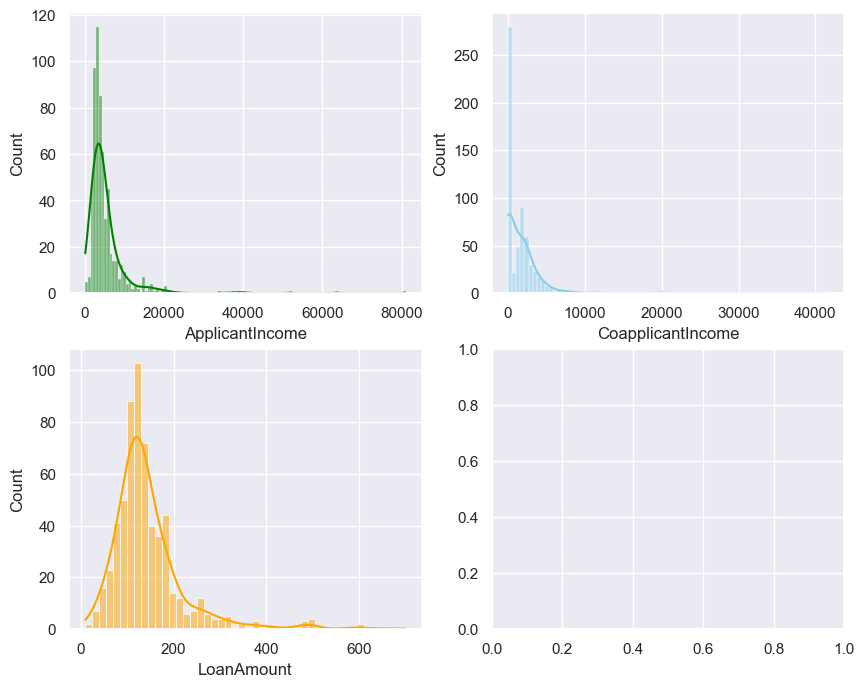

In [16]:
sns.set(style = 'darkgrid')
fig, axs = plt.subplots(2, 2, figsize = (10, 8))

sns.histplot(data = df, x = 'ApplicantIncome', kde = True, ax = axs[0, 0], color = 'green')
sns.histplot(data = df, x = 'CoapplicantIncome', kde = True, ax = axs[0, 1], color= 'skyblue')
sns.histplot(data = df, x = 'LoanAmount', kde = True, ax = axs[1, 0], color = 'orange')
plt.show()

In [17]:
Q1 = df.quantile(0.25)
Q3 =df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis = 1)]

In [18]:
df.ApplicantIncome = np.sqrt(df.ApplicantIncome)
df.CoapplicantIncome = np.sqrt(df.CoapplicantIncome)
df.LoanAmount = np.sqrt(df.LoanAmount)

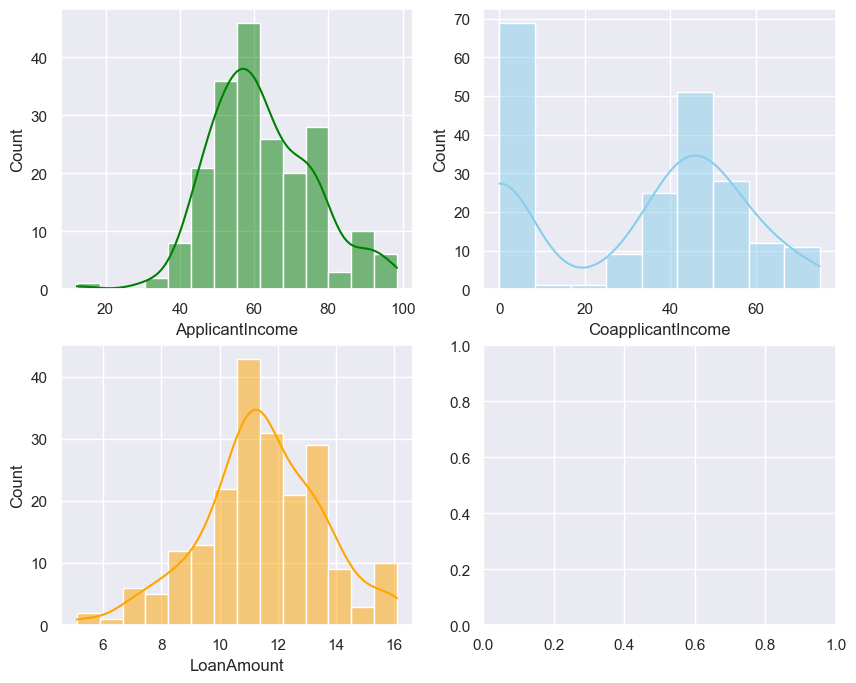

In [19]:
%matplotlib inline
sns.set(style = 'darkgrid')
fig, axs = plt.subplots(2, 2, figsize = (10, 8))

sns.histplot(data = df, x = 'ApplicantIncome', kde = True, ax = axs[0, 0], color = 'green')
sns.histplot(data = df, x = 'CoapplicantIncome', kde = True, ax = axs[0, 1], color = 'skyblue')
sns.histplot(data = df, x = 'LoanAmount', kde = True, ax = axs[1, 0], color = 'orange')
plt.show()

### Feature Separating

In [20]:
X = df.drop('Loan_Status', axis = 1)
y = df['Loan_Status']

In [21]:
X, y = SMOTE().fit_resample(X, y)

C:\Users\HP\AppData\Local\Temp\ipykernel_12652\3468866890.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = y, data = df, palette = 'coolwarm')


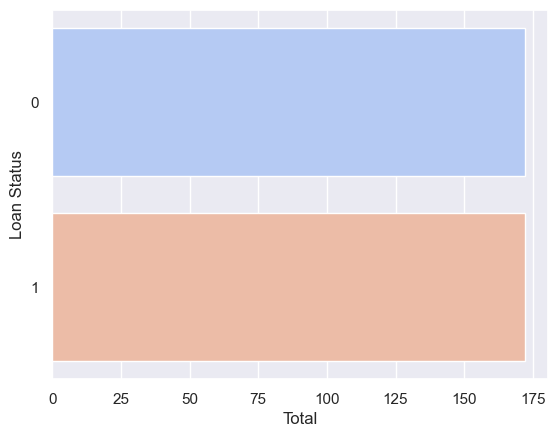

In [22]:
sns.set_theme(style = 'darkgrid')
sns.countplot(y = y, data = df, palette = 'coolwarm')
plt.ylabel('Loan Status')
plt.xlabel('Total')
plt.show()

### Data Normalization

In [23]:
X = MinMaxScaler().fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((275, 11), (69, 11), (275,), (69,))

### Models

#### Logistic Regression

In [26]:
LR_model = LogisticRegression(solver = 'saga', max_iter = 500, random_state = 42)
LR_model.fit(X_train, y_train)

y_pred = LR_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

LRAcc = accuracy_score(y_pred, y_test)
print('LR accuracy: {:.2f}%'.format(LRAcc * 100))

              precision    recall  f1-score   support

           0       0.53      0.50      0.52        32
           1       0.59      0.62      0.61        37

    accuracy                           0.57        69
   macro avg       0.56      0.56      0.56        69
weighted avg       0.56      0.57      0.56        69

[[16 16]
 [14 23]]
LR accuracy: 56.52%


#### K-Nearest Neighbour (KNN)

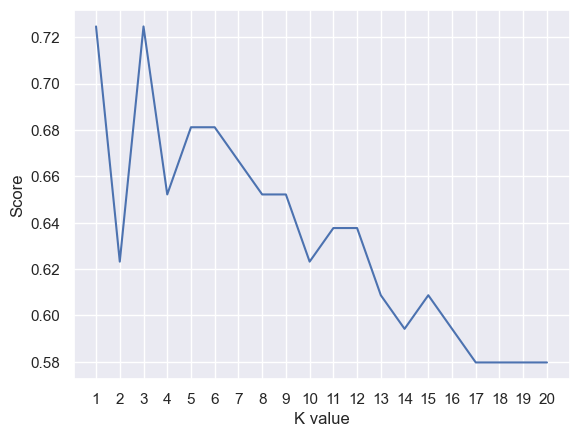

KNN best accuracy: 72.46%


In [27]:
scoreListknn = []
for i in range(1, 21):
    KNClassifier = KNeighborsClassifier(n_neighbors = i)
    KNClassifier.fit(X_train, y_train)
    scoreListknn.append(KNClassifier.score(X_test, y_test))
    
plt.plot(range(1, 21), scoreListknn)
plt.xticks(np.arange(1, 21, 1))
plt.xlabel('K value')
plt.ylabel("Score")
plt.show()
KNAcc = max(scoreListknn)
print('KNN best accuracy: {:.2f}%'.format(KNAcc * 100))

#### Support Vector Machine (SVM) 

In [28]:
SVCclassifier = SVC(kernel = 'rbf', max_iter = 500)
SVCclassifier.fit(X_train, y_train)

y_pred = SVCclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

SVCAcc = accuracy_score(y_pred, y_test)
print('SVC accuracy: {:.2f}%'.format(SVCAcc *100))

              precision    recall  f1-score   support

           0       0.59      0.69      0.64        32
           1       0.69      0.59      0.64        37

    accuracy                           0.64        69
   macro avg       0.64      0.64      0.64        69
weighted avg       0.64      0.64      0.64        69

[[22 10]
 [15 22]]
SVC accuracy: 63.77%


#### Naive Bayes
- Categorical NB

In [29]:
NBclassifier = CategoricalNB()
NBclassifier.fit(X_train, y_train)

y_pred = NBclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

NBAcc = accuracy_score(y_pred, y_test)
print('Categorical Naive Bayes accuracy: {:.2f}%'.format(NBAcc * 100))

              precision    recall  f1-score   support

           0       0.50      0.41      0.45        32
           1       0.56      0.65      0.60        37

    accuracy                           0.54        69
   macro avg       0.53      0.53      0.52        69
weighted avg       0.53      0.54      0.53        69

[[13 19]
 [13 24]]
Categorical Naive Bayes accuracy: 53.62%


- Gaussian NB

In [30]:
NBclassifier2 = GaussianNB()
NBclassifier2.fit(X_train, y_train)

y_pred = NBclassifier2.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

NBAcc2 = accuracy_score(y_pred, y_test)
print('Gaussian Naive Bayes accuracy: {:.2f}%'.format(NBAcc2 * 100))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67        32
           1       0.72      0.57      0.64        37

    accuracy                           0.65        69
   macro avg       0.66      0.66      0.65        69
weighted avg       0.67      0.65      0.65        69

[[24  8]
 [16 21]]
Gaussian Naive Bayes accuracy: 65.22%


#### Decision Tree

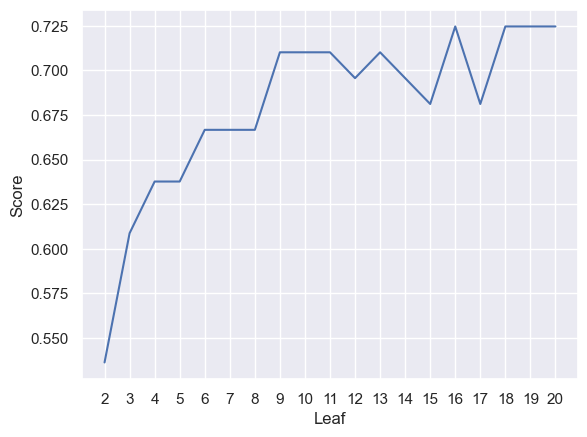

Decision Tree Accuracy: 72.46%


In [31]:
scoreListDT = []
for i in range(2,21):
    DTclassifier = DecisionTreeClassifier(max_leaf_nodes=i)
    DTclassifier.fit(X_train, y_train)
    scoreListDT.append(DTclassifier.score(X_test, y_test))
    
plt.plot(range(2,21), scoreListDT)
plt.xticks(np.arange(2,21,1))
plt.xlabel("Leaf")
plt.ylabel("Score")
plt.show()
DTAcc = max(scoreListDT)
print("Decision Tree Accuracy: {:.2f}%".format(DTAcc*100))

#### Random Forest

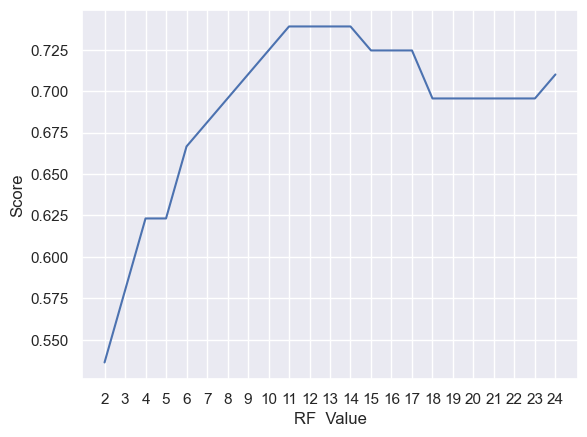

Random Forest Accuracy: 73.91%


In [32]:
scoreListRF = []
for i in range(2, 25):
    RFclassifier = RandomForestClassifier(n_estimators = 1000, random_state = 1, max_leaf_nodes = i)
    RFclassifier .fit(X_train, y_train)
    scoreListRF.append(RFclassifier.score(X_test, y_test))
    
plt.plot(range(2, 25), scoreListRF)
plt.xticks(np.arange(2, 25))
plt.xlabel('RF  Value')
plt.ylabel('Score')
plt.show()
RFAcc = max(scoreListRF)
print('Random Forest Accuracy: {:.2f}%'.format(RFAcc * 100))

#### Gradient Boosting

In [33]:
paramsGB = {'n_estimators': [100, 200, 300, 400, 500],
          'max_depth': [1, 2, 3, 4, 5],
          'subsample': [0.5, 1],
          'max_leaf_nodes': [2, 5, 10, 20, 30, 40, 50]}

In [34]:
GB = RandomizedSearchCV(GradientBoostingClassifier(), paramsGB, cv = 20)
GB.fit(X_train, y_train)

RandomizedSearchCV(cv=20, estimator=GradientBoostingClassifier(),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5],
                                        'max_leaf_nodes': [2, 5, 10, 20, 30, 40,
                                                           50],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.5, 1]})

In [35]:
print(GB.best_estimator_)
print(GB.best_score_)
print(GB.best_params_)
print(GB.best_index_)

GradientBoostingClassifier(max_depth=4, max_leaf_nodes=30, n_estimators=200,
                           subsample=1)
0.7793956043956045
{'subsample': 1, 'n_estimators': 200, 'max_leaf_nodes': 30, 'max_depth': 4}
1


In [36]:
GBclassifier = GradientBoostingClassifier(subsample = 0.5, n_estimators =400, 
                                         max_depth = 4, max_leaf_nodes = 10)
GBclassifier.fit(X_train, y_train)

y_pred = GBclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

GBAcc = accuracy_score(y_test, y_pred)
print('Gradient Boostinh accuracy: {:.2f}%'.format(GBAcc * 100))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84        32
           1       0.91      0.78      0.84        37

    accuracy                           0.84        69
   macro avg       0.85      0.85      0.84        69
weighted avg       0.85      0.84      0.84        69

[[29  3]
 [ 8 29]]
Gradient Boostinh accuracy: 84.06%


### Model Comparison

In [37]:
compare = pd.DataFrame({'Model': ['Logistic Regression', 'K Neighbors',
                                 'SVM', 'Categorical NB',
                                 'Gaussian NB', 'Decision Tree',
                                 'Random Forest', 'Gradient Boosting'],
                       'Accuracy': [LRAcc * 100, KNAcc * 100, SVCAcc * 100,
                                   NBAcc * 100, NBAcc2 * 100, DTAcc * 100,
                                   RFAcc * 100, GBAcc * 100]})
compare.sort_values(by = 'Accuracy', ascending = False)

,Model,Accuracy
7,Gradient Boosting,84.057971
6,Random Forest,73.913043
1,K Neighbors,72.463768
5,Decision Tree,72.463768
4,Gaussian NB,65.217391
2,SVM,63.768116
0,Logistic Regression,56.521739
3,Categorical NB,53.623188
